# import important lib

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

2025-08-05 17:06:41.872044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754413602.074958      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754413602.138325      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **check how many image i have and it's types** 

In [2]:
import os
from PIL import Image

# Set your dataset path
dataset_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

# Counter to stop after 20 images
image_count = 0
max_images = 20

# Loop through all files and subfolders
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    print(f"Image: {file}")
                    print(f"  Path: {file_path}")
                    print(f"  Format: {img.format}")
                    print(f"  Size (W x H): {img.size}")
                    print(f"  Mode: {img.mode}")
                    print(f"  Folder: {os.path.basename(root)}")
                    print("-" * 50)
                    
                    image_count += 1
                    if image_count >= max_images:
                        break
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    if image_count >= max_images:
        break


Image: TCGA_DU_7010_19860307_45.tif
  Path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
  Format: TIFF
  Size (W x H): (256, 256)
  Mode: RGB
  Folder: TCGA_DU_7010_19860307
--------------------------------------------------
Image: TCGA_DU_7010_19860307_56_mask.tif
  Path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
  Format: TIFF
  Size (W x H): (256, 256)
  Mode: L
  Folder: TCGA_DU_7010_19860307
--------------------------------------------------
Image: TCGA_DU_7010_19860307_57.tif
  Path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
  Format: TIFF
  Size (W x H): (256, 256)
  Mode: RGB
  Folder: TCGA_DU_7010_19860307
--------------------------------------------------
Image: TCGA_DU_7010_19860307_33.tif
  Path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
  Format: TIFF
  Size

# separte the mask and MRI images

In [3]:
import os
import shutil

DATA_DIR = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

images_dir = '/kaggle/working/images/'
masks_dir = '/kaggle/working/masks/'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

temp_images = []
temp_masks = []

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith('.tif'):
            if 'mask' in file.lower():
                shutil.copy(os.path.join(root, file), os.path.join(masks_dir, file))
                temp_masks.append(file)
            else:
                shutil.copy(os.path.join(root, file), os.path.join(images_dir, file))
                temp_images.append(file)

final_images = []
final_masks = []

for img_file in sorted(temp_images):
    expected_mask = img_file.replace('.tif', '_mask.tif')
    if expected_mask in temp_masks:
        final_images.append(img_file)
        final_masks.append(expected_mask)

print(f"Total matched image-mask pairs: {len(final_images)}")
print(f"Total images copied: {len(temp_images)}")
print(f"Total masks copied: {len(temp_masks)}")

Total matched image-mask pairs: 3929
Total images copied: 3929
Total masks copied: 3929


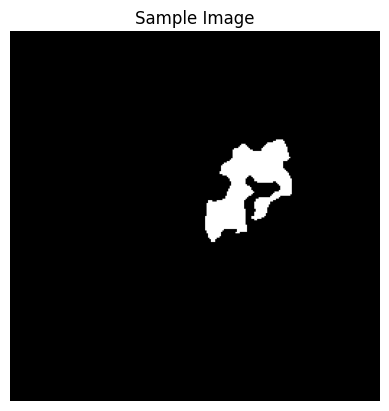

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image
image_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31_mask.tif"

# Open and display the image
img = Image.open(image_path)

plt.imshow(img, cmap='gray' if img.mode == 'L' else None)
plt.axis('off')  # Hide axes
plt.title("Sample Image")
plt.show()

In [5]:
from PIL import Image
import numpy as np

black_mask_count = 0

for mask_file in final_masks:
    mask_path = os.path.join(masks_dir, mask_file)
    mask = Image.open(mask_path).convert('L')  # Convert to grayscale
    mask_array = np.array(mask)

    if np.sum(mask_array) == 0:
        black_mask_count += 1

print(f"Total black (empty) masks: {black_mask_count}")


Total black (empty) masks: 2556


# visualize the MRI & Its mask

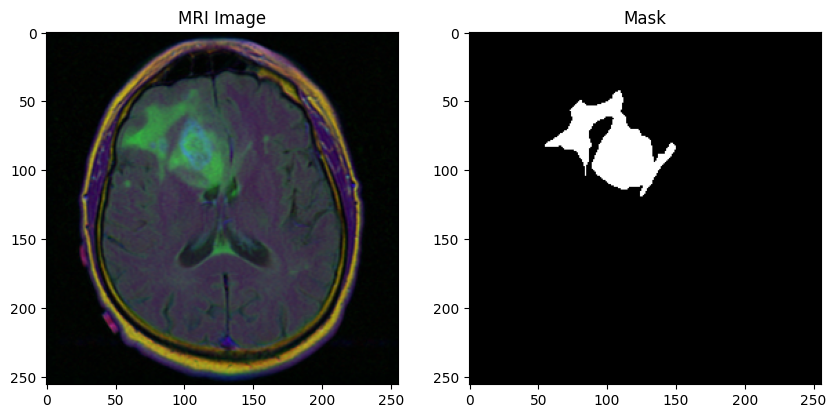

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

def show_image_mask_pair(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('MRI Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    
    plt.show()

# Example
show_image_mask_pair(os.path.join(images_dir, final_images[5]),
                     os.path.join(masks_dir, final_masks[5]))

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array, load_img

IMG_SIZE = 256

X = []
Y = []

for img_file, mask_file in zip(final_images, final_masks):
    img = load_img(os.path.join(images_dir, img_file), target_size=(IMG_SIZE, IMG_SIZE))
    mask = load_img(os.path.join(masks_dir, mask_file), target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
    
    img = img_to_array(img) / 255.0
    mask = img_to_array(mask) / 255.0  # make sure mask is 0 or 1
    
    X.append(img)
    Y.append(mask)

X = np.array(X)
Y = np.array(Y)


Y = (Y > 0.5).astype(np.float32)

# Split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Identyfiy UNET Arch

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)

    
    u4 = UpSampling2D()(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = UpSampling2D()(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    return Model(inputs=[inputs], outputs=[outputs])

model = build_unet((IMG_SIZE, IMG_SIZE, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1754413692.414236      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

# Start Training

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')

model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
          epochs=20, batch_size=8, callbacks=[early_stop])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
I0000 00:00:1754413706.358663      97 service.cc:148] XLA service 0x789218009950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754413706.359426      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754413706.913790      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/393 ━━━━━━━━━━━━━━━━━━━━ 2:02:27 19s/step - accuracy: 0.0251 - loss: 0.6949

I0000 00:00:1754413720.297368      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9733 - loss: 0.0762

E0000 00:00:1754413769.709933      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754413769.950320      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754413770.588555      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754413770.847813      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


393/393 ━━━━━━━━━━━━━━━━━━━━ 90s 181ms/step - accuracy: 0.9734 - loss: 0.0760 - val_accuracy: 0.9927 - val_loss: 0.0294
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.9918 - loss: 0.0283 - val_accuracy: 0.9928 - val_loss: 0.0246
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.9924 - loss: 0.0254 - val_accuracy: 0.9929 - val_loss: 0.0236
Epoch 4/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.9924 - loss: 0.0247 - val_accuracy: 0.9931 - val_loss: 0.0221
Epoch 5/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.9927 - loss: 0.0237 - val_accuracy: 0.9932 - val_loss: 0.0218
Epoch 6/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.9926 - loss: 0.0243 - val_accuracy: 0.9932 - val_loss: 0.0230
Epoch 7/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.9934 - loss: 0.0211 - val_accuracy: 0.9937 - val_loss: 0.0196
Epoch 8/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.9935 - loss: 0.0201 - val

# Test the model 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(5, 256, 256, 3))
  warnings.warn(msg)
E0000 00:00:1754414764.620097      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754414764.858345      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754414765.426180      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754414765.688038      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup executio

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


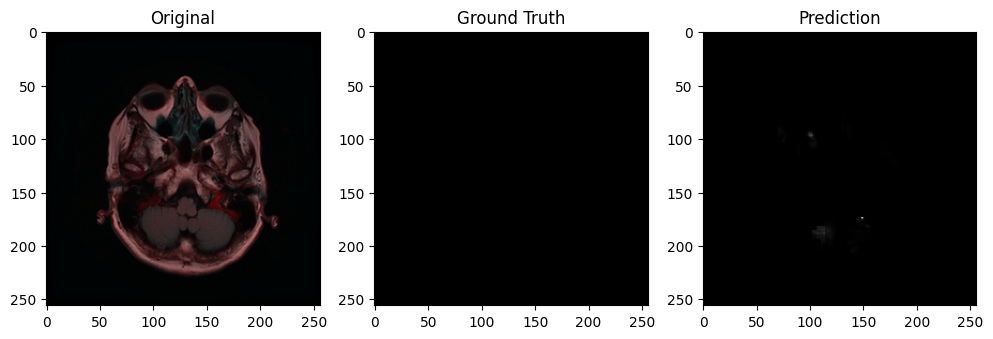

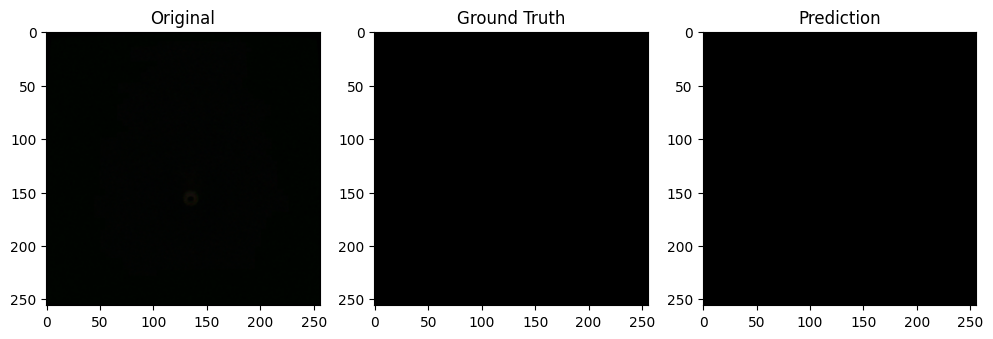

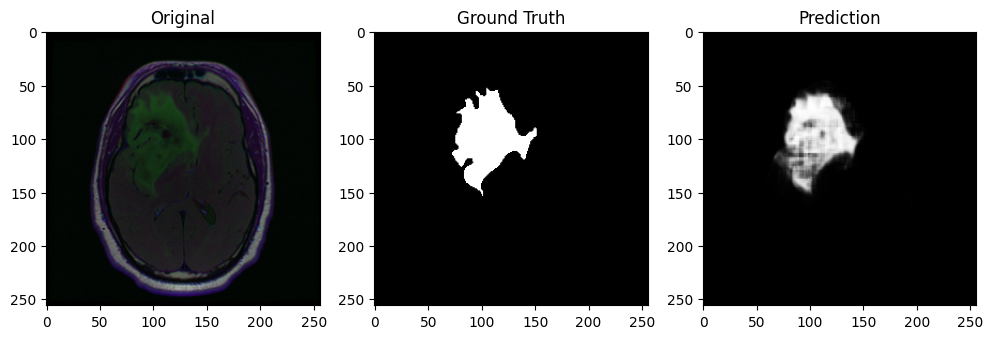

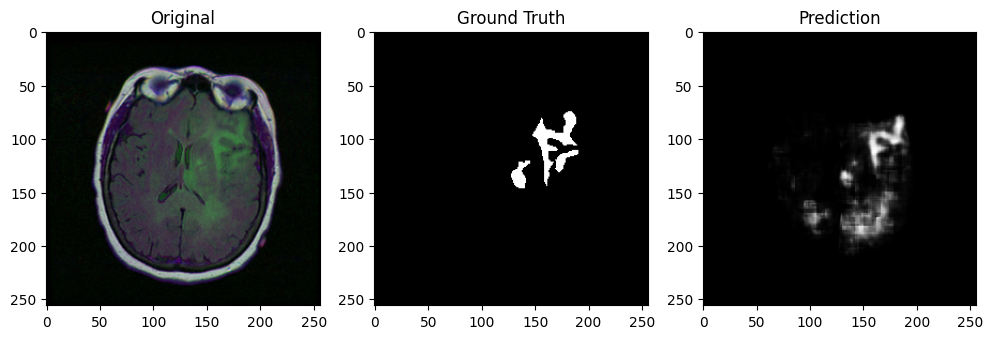

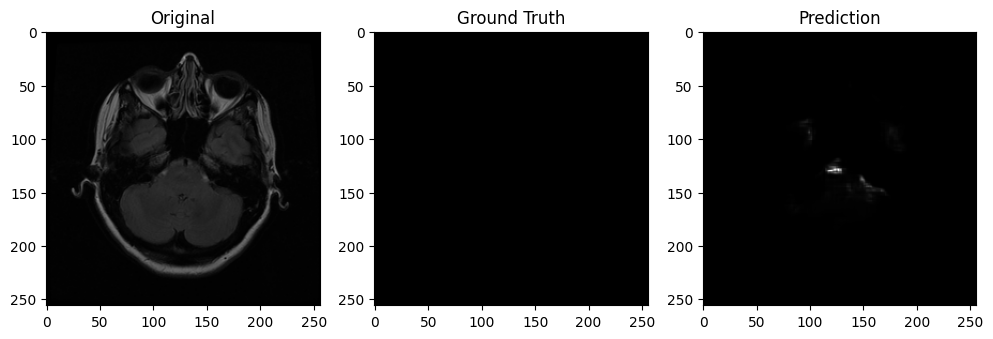

In [10]:
preds = model.predict(X_val[:5])
for i in range(5):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,3,1)
    plt.imshow(X_val[i])
    plt.title("Original")

    plt.subplot(1,3,2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Prediction")

    plt.show()


In [12]:
model.save('my_model.h5')  # Saves in HDF5 format